In [1]:
# Reed Whitcraft
# Mod 02 Final Project

# Table of Contents
***

    1. Observation
    2. Examine Research
    3. Form Hypothesis
    4. Conduct Experiment
    5. Analyze Experimental Results
    6. Draw Conclusions

# Lab Links
***
- [Querying with SQLAlchemy](https://learn.co/tracks/data-science-career-v1-1/module-2-advanced-data-retrieval-and-analysis/section-15-an-introduction-to-orms/querying-with-sqlalchemy)
- [Querying with SQLAlchemy - Lab (Solution)](https://github.com/learn-co-students/dsc-2-13-11-queries-with-sqlalchemy-lab-online-ds-ft-021119/tree/solution)
- [Using an ORM](https://learn.co/tracks/data-science-career-v1-1/module-2-advanced-data-retrieval-and-analysis/section-15-an-introduction-to-orms/using-an-orm)
- [Using an ORM - Lab (Solution)](https://github.com/learn-co-students/dsc-2-13-08-using-an-orm-lab-online-ds-ft-021119/tree/solution)
- [Using Sqlite - Lab (Solution)](https://github.com/learn-co-students/dsc-2-13-04-review-using-sqlite-lab-online-ds-ft-021119/tree/solution)
- [Nested Queries with SQLAlchemy](https://blog.miguelgrinberg.com/post/nested-queries-with-sqlalchemy-orm)
- [Two Sample T-Test - Lab (Solution)](https://github.com/learn-co-students/dsc-2-20-09-2-sample-t-tests-lab-online-ds-ft-021119/tree/solution)
- [Learn.co - Effect Size (Cohen d)](https://learn.co/tracks/data-science-career-v1-1/module-2-advanced-data-retrieval-and-analysis/section-20-hypothesis-and-ab-testing/effect-sizes)
- [Effect Size](https://www.statisticssolutions.com/statistical-analyses-effect-size/)
- [Introduction to Sampling](https://learn.co/tracks/data-science-career-v1-1/module-2-advanced-data-retrieval-and-analysis/section-19-distributions-and-sampling/introduction-to-sampling)


# Database Details

<table>
    <thead>
        <tr>
            <th>Table Name</th>
            <th>Primary Key</th>
            <th>Foreign Key(s)</th>
            <th>Count</th>
        </tr>
    </thead>
    <tbody>
        <tr><td>Product</td><td>d</td><td>d</td><td>77</td></tr>
        <tr><td>Category</td><td>d</td><td>d</td><td>8</td></tr>
        <tr><td>Order</td><td>d</td><td>d</td><td>830</td></tr>
        <tr><td>OrderDetail</td><td>d</td><td>d</td><td>2155</td></tr>
        <tr><td>Customer</td><td>d</td><td>d</td><td>91</td></tr>
    </tbody>
</table>

In [21]:
# import dependencies
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import sqlalchemy
import sqlite3 as sql
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from ipywidgets import interact, interactive

In [4]:
# helper methods :)

def effect_size_blurb(effect_size):
    e_size = ""
    if effect_size <= 0.20:
        e_size = "small"
    elif effect_size >0.20 and effect_size <=0.50:
        e_size = "small/medium"
    elif effect_size > 0.50 and effect_size <=0.80:
        e_size = "medium/large"
    elif effect_size > 0.80 and effect_size <=1.20:
        e_size = "large/very large"
    else:
        e_size = "huge" 
        
    init = "Effect size is a measurement of the strength of a relationship between two variables on a numeric scale, and Cohen's d calculates this as the difference between two means divided by a standard deviation for the combined data. "
    init2 = "Generally, 0.01 is considered very small, 0.20 small, 0.50 medium, 0.80 large, 1.20 very large, and 2.0 huge. "
    init3 = "Typically, a lower Cohen's d score indicates the need for larger sample sizes. "
    init4 = "With a cohen's d value of " + str(round(effect_size, 3)) + ", we can say that the effect size is " + e_size
    
    return init + init2 + init3 + init4
    
    

In [5]:
# Open a connection to the sql server. I'll use sqlite3 for now, but I may switch to another sql module later if I need it.
connect = sql.connect('Northwind_small.sqlite')
c = connect.cursor()
# Get table names
raw = c.execute("""select name from sqlite_master where type = 'table'""").fetchall()
tables = []
for table in raw:
    tables.append(table[0])
    
print(tables)

['Employee', 'Category', 'Customer', 'Shipper', 'Supplier', 'Order', 'Product', 'OrderDetail', 'CustomerCustomerDemo', 'CustomerDemographic', 'Region', 'Territory', 'EmployeeTerritory']


In [6]:
@interact
def table_preview(Table = tables, Preview = ['Head','Description', 'Shape','Unique','Types']):
    statement = "SELECT * FROM [" + Table + "]"
    print(statement)
    df = pd.read_sql_query(statement, connect)
    preview_return = {'Head':df.head(10), 'Description':df.describe(), 
                      'Shape':df.shape, 'Unique':df.nunique(axis = 0), 'Types':df.dtypes}
    out = preview_return[Preview]
    return out

interactive(children=(Dropdown(description='Table', options=('Employee', 'Category', 'Customer', 'Shipper', 'S…

In [7]:
# connecting to database
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()
inspector = inspect(engine)
print(inspector.get_table_names()) # print table names

2019-04-03 20:21:26,738 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-04-03 20:21:26,739 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:26,740 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-04-03 20:21:26,740 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:26,743 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-03 20:21:26,744 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [8]:
from sqlalchemy.sql import func

In [9]:
from sqlalchemy import MetaData
from sqlalchemy.ext.automap import automap_base

metadata = MetaData()
metadata.reflect(engine)
Base = automap_base(metadata=metadata)
Base.prepare()

2019-04-03 20:21:27,488 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-04-03 20:21:27,488 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,490 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Category")
2019-04-03 20:21:27,491 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,493 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-04-03 20:21:27,494 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,495 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("Category")
2019-04-03 20:21:27,496 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,497 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Category' AND type = 'table'
2019-04-03 20:21:27,498 INFO sqlalchemy.engine.base.Engin

2019-04-03 20:21:27,563 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("EmployeeTerritory")
2019-04-03 20:21:27,563 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,564 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'EmployeeTerritory' AND type = 'table'
2019-04-03 20:21:27,565 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,566 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("EmployeeTerritory")
2019-04-03 20:21:27,567 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,567 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("EmployeeTerritory")
2019-04-03 20:21:27,568 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,569 INFO sqlalchemy.engine.base.Engine PRAGMA index_info("sqlite_autoindex_EmployeeTerritory_1")
2019-04-03 20:21:27,569 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,570 INFO sqlalchemy.engine.base.Engine SELECT sql 

2019-04-03 20:21:27,655 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Supplier")
2019-04-03 20:21:27,656 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,658 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Supplier' AND type = 'table'
2019-04-03 20:21:27,659 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,660 INFO sqlalchemy.engine.base.Engine PRAGMA foreign_key_list("Supplier")
2019-04-03 20:21:27,661 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,662 INFO sqlalchemy.engine.base.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = 'Supplier' AND type = 'table'
2019-04-03 20:21:27,662 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,664 INFO sqlalchemy.engine.base.Engine PRAGMA index_list("Supplier")
2019-04-03 20:21:27,664 INFO sqlalchemy.engine.base.Engine ()
2019-04-03 20:21:27,666 INFO 

In [10]:
# Mapping to classes
Employee, Customer = Base.classes.Employee, Base.classes.Customer
Product, Category = Base.classes.Product, Base.classes.Category
Order, OrderDetail = Base.classes.Order, Base.classes.OrderDetail

## 3.1 Hypothesis Test 01

### Question: Do discounts increase the overall order size?

Economically, there is a negative relationship between price and demand - as price goes up, demand falls, and as price goes down, demand rises.  For this case study, I will look to see if the presence of discounts (decrease in price) increases the overall order size (quantity demanded) by comparing the average total quantities ordered in two groups - (1) Orders that have at least one item discounted (Discounted), and (2) Orders that contain no discounted items (Undiscounted).

Formally,

#### Null Hypothesis

>**Ho:** Discounted Mean Quantity Ordered = Undiscounted Mean Quantity Ordered

#### Alternate Hypothesis

>**Ha:** Discounted Mean Quantity Ordered > Undiscounted Mean Quantity Ordered

First, we have to query our database - aggregating the OrderDetails (line items) for each Order, and separating discounted and undiscounted orders.

In [18]:
# query OrderDetail => grouped (aggregated) by Order (Orders have many OrderDetails)
# sum quantities across OrderDetail that belong to same Order
# find MaxDiscount that belong to same Order (to determine non-discounted orders, which will = 0)
subquery = session.query(OrderDetail, 
                         func.sum(OrderDetail.Quantity).label("TotalQuantity"), 
                         func.max(OrderDetail.Discount).label("MaxDiscount"), 
                         func.min(OrderDetail.Discount).label("MinDiscount")
                        ).group_by(OrderDetail.OrderId).subquery()

query = session.query(subquery).filter(subquery.c.MaxDiscount > 0).group_by(subquery.c.OrderId)
undiscounted_orders = pd.read_sql(query.statement, engine) # 450

# same as query above, *EXCEPT* filtering for MaxDiscount == 0
# this way, we have orders that have no items with discounts
subquery2 = session.query(OrderDetail, 
                         func.sum(OrderDetail.Quantity).label("TotalQuantity"), 
                         func.max(OrderDetail.Discount).label("MaxDiscount"), 
                         func.min(OrderDetail.Discount).label("MinDiscount")
                        ).group_by(OrderDetail.OrderId).subquery()

query2 = session.query(subquery2).filter(subquery2.c.MaxDiscount == 0).group_by(subquery2.c.OrderId)
discounted_orders = pd.read_sql(query2.statement, engine) # 380

2019-04-03 20:23:02,316 INFO sqlalchemy.engine.base.Engine SELECT anon_1."Id", anon_1."OrderId", anon_1."ProductId", anon_1."UnitPrice", anon_1."Quantity", anon_1."Discount", anon_1."TotalQuantity", anon_1."MaxDiscount", anon_1."MinDiscount" 
FROM (SELECT "OrderDetail"."Id" AS "Id", "OrderDetail"."OrderId" AS "OrderId", "OrderDetail"."ProductId" AS "ProductId", "OrderDetail"."UnitPrice" AS "UnitPrice", "OrderDetail"."Quantity" AS "Quantity", "OrderDetail"."Discount" AS "Discount", sum("OrderDetail"."Quantity") AS "TotalQuantity", max("OrderDetail"."Discount") AS "MaxDiscount", min("OrderDetail"."Discount") AS "MinDiscount" 
FROM "OrderDetail" GROUP BY "OrderDetail"."OrderId") AS anon_1 
WHERE anon_1."MaxDiscount" > ? GROUP BY anon_1."OrderId"
2019-04-03 20:23:02,317 INFO sqlalchemy.engine.base.Engine (0,)
2019-04-03 20:23:02,327 INFO sqlalchemy.engine.base.Engine SELECT anon_1."Id", anon_1."OrderId", anon_1."ProductId", anon_1."UnitPrice", anon_1."Quantity", anon_1."Discount", anon_1."

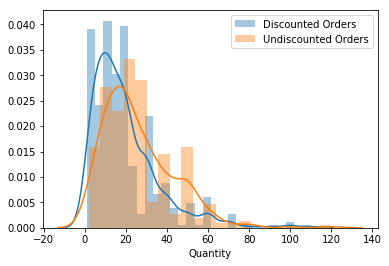

In [19]:
# Take a look at the distributions of these orders' quantities
sns.distplot(discounted_orders.Quantity, label="Discounted Orders")
sns.distplot(undiscounted_orders.Quantity, label="Undiscounted Orders")
plt.legend()

#### Confirming non-normality of order distributions

Here, we'll use the Shapiro-Wilk normality test, which tests if a random sample comes from a normal distribution.

>Ho: Sample data is normally distributed

>Ha: Sample data is not normally distributed

Here, if we get a p-value less than 0.05, we have to reject our null hypothesis that the data is normally distributed, and accept that the data is not from a normal distribution.  Ideally, we want the null hypothesis to not be rejected (but, correctly!), but that rarely happens with real data and large samples.  If the null hypothesis is rejectable, then we'll have to consider repeated sampling or normalization (log).

In [26]:
shapiro_discounted = stats.shapiro(discounted_orders.Quantity)
shapiro_undiscounted = stats.shapiro(undiscounted_orders.Quantity)
shapiro_p_d = shapiro_discounted[1] # p-value for discounted orders distribution test
shapiro_p_ud = shapiro_undiscounted[1] # p-value for undiscounted orders distribution test
print("p-value for discounted orders: ", shapiro_p_d)
print("p-value for undiscounted orders: ", shapiro_p_ud)
print('t-stat for discounted orders: ', shapiro_discounted[1])
print('t-stat for undiscounted orders: ', shapiro_undiscounted[1])
# p-value (discounted) => reject null hypothesis => not normally distributed sample
# p-value (undiscounted) => reject null hypothesis => not normally distributed sample

p-value for discounted orders:  2.308488827657349e-21
p-value for undiscounted orders:  1.4756438800923866e-14
t-stat for discounted orders:  2.308488827657349e-21
t-stat for undiscounted orders:  1.4756438800923866e-14


In [13]:
# Normalize the orders because hypothesis test has this as an assumption
log_undiscounted = np.log(undiscounted_orders.Quantity)
log_discounted = np.log(discounted_orders.Quantity)
undiscounted_orders.Quantity = log_undiscounted
discounted_orders.Quantity = log_discounted

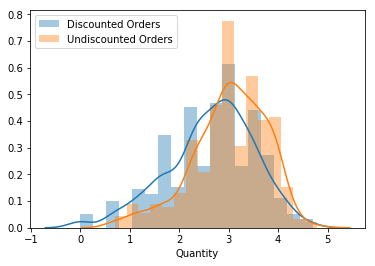

In [14]:
# Second look at the distributions
sns.distplot(discounted_orders.Quantity, label="Discounted Orders")
sns.distplot(undiscounted_orders.Quantity, label="Undiscounted Orders")
plt.legend()

In [15]:
# helper method to measure effect size
# represents the magnitude of differences between two groups on a given variable
# with larger values representing a greater differentation between two groups on that variable

def pooled_var(group1, group2, col_name):
    n1, n2 = len(group1), len(group2)
    var1 = group1[col_name].var()
    var2 = group2[col_name].var()
    
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    return pooled_var

# for calculating effect size
def cohens_d(group1, group2, col_name):
    diff = group1[col_name].mean() - group2[col_name].mean()
    
    # calculate pooled threshold
    pooled_v = pooled_var(group1, group2, col_name)
    
    # calculate cohen's d statistic
    d = diff / np.sqrt(pooled_v)
    
    return d

In [16]:
from statsmodels.stats.weightstats import ttest_ind
# import scipy.stats

tstat, pvalue, df = ttest_ind(undiscounted_orders.Quantity, discounted_orders.Quantity, alternative='larger')

# calculate pooled variance
pooled_v = pooled_var(undiscounted_orders, discounted_orders, "Quantity")
# calculate effect size using cohen's d
cohen_d = cohens_d(undiscounted_orders, discounted_orders, "Quantity")

print('p-value = {0:1.3e}'.format(pvalue))
print('t-stat = {0:1.3f}'.format(tstat))
print('cohen d = {0:1.3f}'.format(cohen_d))

e = effect_size_blurb(cohen_d)

p-value = 1.122e-10
t-stat = 6.423
cohen d = 0.448


Given the p-value of {{pvalue}}, which is < our set significance level of 0.05, and the t-statistic of {{tstat}}, we can confidently reject the null hypothesis in favor of our alternative hypothesis.  That is, we can say that the average quantity order of discounted orders and undiscounted orders are not the same, and discounted orders have a higher average quantity of items.  

{{e}}


## 3.1 Hypothesis Test 02

***

### Question: Do discount rates have different effects on demand? Are higher discounts more effective in increasing quantity demanded than lower discounts?

Same scenario as before - a decrease in price, typically, results in an increase in demand.  In theory, a greater decrease in price should result in a greater increase in quantity demanded. Let's take a look at the types of discounts that have been offered.



In [53]:
# query OrderDetail table for Discount & count the appearances of Discount
subquery = session.query(OrderDetail.Discount,
                      func.count(OrderDetail.Discount).label("DiscountCount")
                     ).group_by(OrderDetail.Discount).subquery()

query = session.query(subquery
                     ).order_by(subquery.c.DiscountCount.desc())

discount_counts = pd.read_sql(query.statement, engine)
print("Total Number of OrderDetails:", discount_counts.DiscountCount.sum())
discount_counts.head(11)

2019-04-03 11:24:57,139 INFO sqlalchemy.engine.base.Engine SELECT anon_1."Discount", anon_1."DiscountCount" 
FROM (SELECT "OrderDetail"."Discount" AS "Discount", count("OrderDetail"."Discount") AS "DiscountCount" 
FROM "OrderDetail" GROUP BY "OrderDetail"."Discount") AS anon_1 ORDER BY anon_1."DiscountCount" DESC
2019-04-03 11:24:57,140 INFO sqlalchemy.engine.base.Engine ()
Total Number of OrderDetails: 2155


,Discount,DiscountCount
0,0.00,1317
1,0.05,185
2,0.10,173
3,0.20,161
4,0.15,157
5,0.25,154
6,0.03,3
7,0.02,2
8,0.01,1
9,0.04,1


<table>
    <thead>
        <tr>
            <th colspan="3" style="text-align: center">Out of the 2,155 OrderDetails</th>
        </tr>
        <tr>
            <th># Of OrderDetails</th>
            <th>Discount</th>
            <th>% Of All OrderDetails</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: center">1,317</td>
            <td style="text-align: center">0%</td>
            <td style="text-align: center">61.1%</td>
        </tr>
        <tr>
            <td style="text-align: center">185</td>
            <td style="text-align: center">5%</td>
            <td style="text-align: center">8.5%</td>
        </tr>
        <tr>
            <td style="text-align: center">173</td>
            <td style="text-align: center">10%</td>
            <td style="text-align: center">8.0%</td>
        </tr>
        <tr>
            <td style="text-align: center">161</td>
            <td style="text-align: center">20%</td>
            <td style="text-align: center">7.5%</td>
        </tr>
        <tr>
            <td style="text-align: center">157</td>
            <td style="text-align: center">15%</td>
            <td style="text-align: center">7.3%</td>
        </tr>
        <tr>
            <td style="text-align: center">154</td>
            <td style="text-align: center">25%</td>
            <td style="text-align: center">7.1%</td>
        </tr>
    </tbody>
</table>

In [82]:
# takes Discount (fraction) as input and returns TotalQuantity
# from OrderDetails that have the chosen Discount
def query_orders_by_discount(discount):
    query = session.query(OrderDetail.OrderId, 
                            func.sum(OrderDetail.Quantity).label("TotalQuantity")
                            ).filter(OrderDetail.Discount == discount).group_by(OrderDetail.OrderId)
    orders = pd.read_sql(query.statement, engine)
    return orders

In [120]:
discount_0 = query_orders_by_discount(0)
discount_5 = query_orders_by_discount(0.05)
discount_10 = query_orders_by_discount(0.10)
discount_15 = query_orders_by_discount(0.15)
discount_20 = query_orders_by_discount(0.20)
discount_25 = query_orders_by_discount(0.25)

2019-04-03 16:09:05,030 INFO sqlalchemy.engine.base.Engine SELECT "OrderDetail"."OrderId", sum("OrderDetail"."Quantity") AS "TotalQuantity" 
FROM "OrderDetail" 
WHERE "OrderDetail"."Discount" = ? GROUP BY "OrderDetail"."OrderId"
2019-04-03 16:09:05,030 INFO sqlalchemy.engine.base.Engine (0,)
2019-04-03 16:09:05,037 INFO sqlalchemy.engine.base.Engine SELECT "OrderDetail"."OrderId", sum("OrderDetail"."Quantity") AS "TotalQuantity" 
FROM "OrderDetail" 
WHERE "OrderDetail"."Discount" = ? GROUP BY "OrderDetail"."OrderId"
2019-04-03 16:09:05,038 INFO sqlalchemy.engine.base.Engine (0.05,)
2019-04-03 16:09:05,042 INFO sqlalchemy.engine.base.Engine SELECT "OrderDetail"."OrderId", sum("OrderDetail"."Quantity") AS "TotalQuantity" 
FROM "OrderDetail" 
WHERE "OrderDetail"."Discount" = ? GROUP BY "OrderDetail"."OrderId"
2019-04-03 16:09:05,043 INFO sqlalchemy.engine.base.Engine (0.1,)
2019-04-03 16:09:05,047 INFO sqlalchemy.engine.base.Engine SELECT "OrderDetail"."OrderId", sum("OrderDetail"."Quanti

In [121]:
preview_select = ["0%", "5%", "10%", "15%", "20%", "25%"]
preview_hash = {"0%": discount_0, "5%": discount_5, "10%": discount_10, "15%": discount_15, "20%": discount_20, "25%": discount_25}
@interact
def table_preview(Table = preview_select, Preview = ['Head','Description']):
    df = preview_hash[Table]
    preview_return = {'Head':df.head(10), 'Description':df.describe()}
    out = preview_return[Preview]
    return out

interactive(children=(Dropdown(description='Table', options=('0%', '5%', '10%', '15%', '20%', '25%'), value='0…

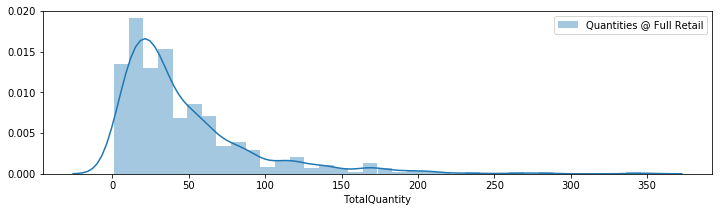

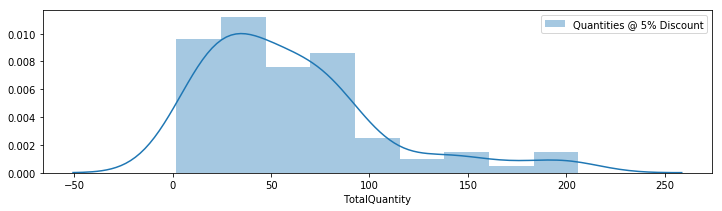

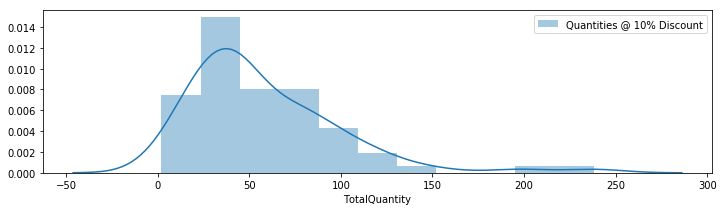

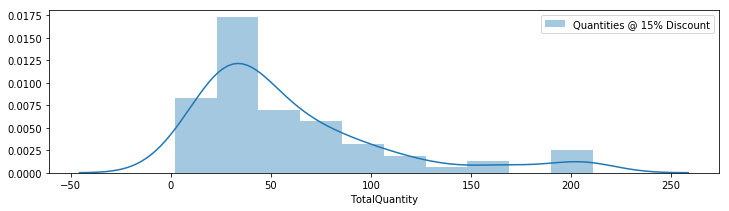

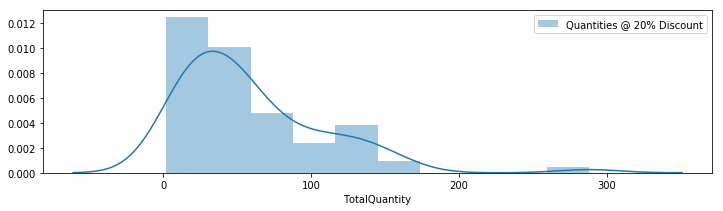

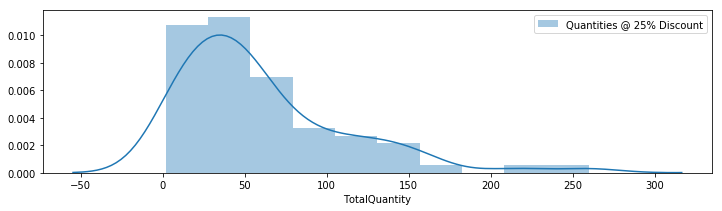

In [122]:
# Take a look at the distributions of quantities ordered at given discount rates
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_0.TotalQuantity, label="Quantities @ Full Retail")
plt.legend()
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_5.TotalQuantity, label="Quantities @ 5% Discount")
plt.legend()
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_10.TotalQuantity, label="Quantities @ 10% Discount")
plt.legend()
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_15.TotalQuantity, label="Quantities @ 15% Discount")
plt.legend()
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_20.TotalQuantity, label="Quantities @ 20% Discount")
plt.legend()
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_25.TotalQuantity, label="Quantities @ 25% Discount")
plt.legend()


Looking at the distributions of quantities ordered at each discount level, we can see that none of them are perfectly normally distributed, and they are skewed, so before comparing different discount rates, let's normalize each of these.

In [123]:
# take log of TotalQuantity
log_discount_0 = np.log(discount_0.TotalQuantity)
log_discount_5 = np.log(discount_5.TotalQuantity)
log_discount_10 = np.log(discount_10.TotalQuantity)
log_discount_15 = np.log(discount_15.TotalQuantity)
log_discount_20 = np.log(discount_20.TotalQuantity)
log_discount_25 = np.log(discount_25.TotalQuantity)

# overwrite original data
discount_0.TotalQuantity = log_discount_0
discount_5.TotalQuantity = log_discount_5
discount_10.TotalQuantity = log_discount_10
discount_15.TotalQuantity = log_discount_15
discount_20.TotalQuantity = log_discount_20
discount_25.TotalQuantity = log_discount_25

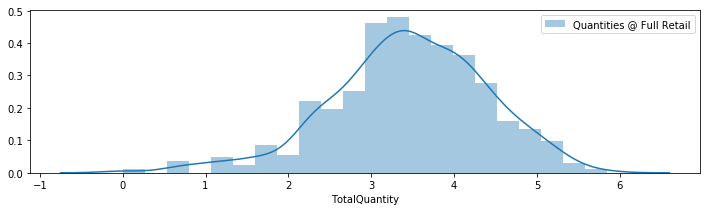

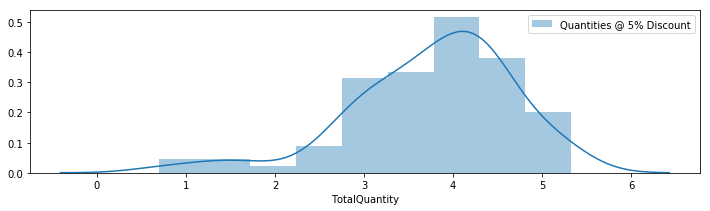

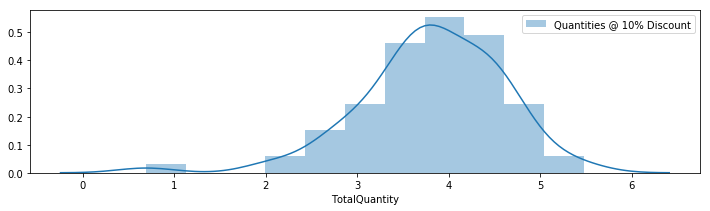

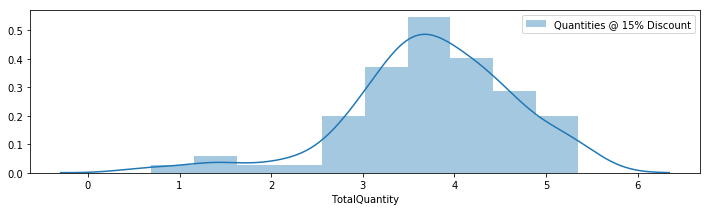

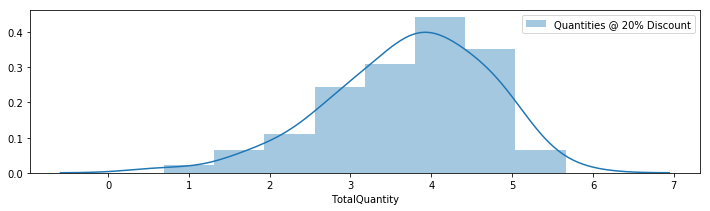

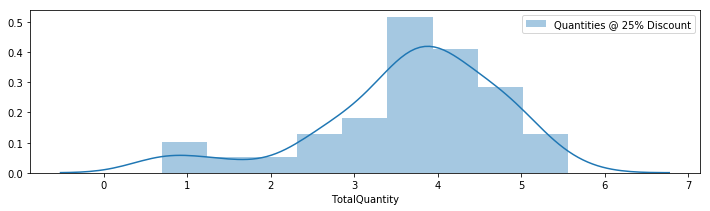

In [132]:
# Take a look at the normalized distributions of quantities ordered at given discount rates
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_0.TotalQuantity, label="Quantities @ Full Retail")
plt.legend()
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_5.TotalQuantity, label="Quantities @ 5% Discount")
plt.legend()
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_10.TotalQuantity, label="Quantities @ 10% Discount")
plt.legend()
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_15.TotalQuantity, label="Quantities @ 15% Discount")
plt.legend()
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_20.TotalQuantity, label="Quantities @ 20% Discount")
plt.legend()
fig = plt.figure(figsize=(12,3))
sns.distplot(discount_25.TotalQuantity, label="Quantities @ 25% Discount")
plt.legend()


In [125]:
from statsmodels.stats.weightstats import ttest_ind
# import scipy.stats

tstat, pvalue, df = ttest_ind(discount_5.TotalQuantity, discount_10.TotalQuantity, alternative='larger')

# calculate pooled variance
pooled_v = pooled_var(discount_5, discount_10, "TotalQuantity")
# calculate effect size using cohen's d
cohen_d = cohens_d(discount_5, discount_10, "TotalQuantity")

print('p-value = {0:1.3e} \n hey'.format(pvalue))
print('t-stat = {0:1.3f}'.format(tstat))
print('cohen d = {0:1.3f}'.format(cohen_d))

e = effect_size_blurb(cohen_d)

p-value = 6.386e-01 
 hey
t-stat = -0.355
cohen d = -0.056


In [133]:
@interact
def table_preview(Discount1 = ['25%', '20%', '15%', '10%', '5%', '0%'], Discount2 = ['5%','10%','15%', '20%', '25%', '0%']):
    
    discount_dict = {
        '0%': discount_0,
        '5%': discount_5, 
        '10%':discount_10, 
        '15%':discount_15, 
        '20%': discount_20, 
        '25%': discount_25
    }
    selected_discount_1 = discount_dict[Discount1]
    selected_discount_2 = discount_dict[Discount2]
    tstat, pvalue, df = ttest_ind(selected_discount_1.TotalQuantity, selected_discount_2.TotalQuantity, usevar='unequal', alternative='larger')
    
    # calculate pooled variance
    pooled_v = pooled_var(selected_discount_1, selected_discount_2, "TotalQuantity")
    
    # calculate effect size using cohen's d
    cohen_d = cohens_d(selected_discount_1, selected_discount_2, "TotalQuantity")
    
    print("Comparing {} Discount vs. {} Discount, we get the following:".format(Discount1, Discount2))
    print('p-value = {0:1.3e} \n hey'.format(pvalue))
    print('t-stat = {0:1.3f}'.format(tstat))
    print('cohen d = {0:1.3f}'.format(cohen_d))

interactive(children=(Dropdown(description='Discount1', options=('25%', '20%', '15%', '10%', '5%', '0%'), valu…

<table>
    <thead>
        <tr>
            <th>Comparison</th>
            <th>P-Value</th>
            <th>T-Stat</th>
            <th>Cohen's d</th>
            <th>Accept/Reject Null</th>
            <th>Effect Size</th>
            <th>Conclusion</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>25% vs. Full Retail</td>
            <td>5.348e-02</td>
            <td>1.630</td>
            <td>0.228</td>
            <td>Accept Null</td>
            <td>Small</td>
            <td>P value close to 0.05, but above; low t-stat</td>
        </tr>
        <tr>
            <td>20% vs. Full Retail</td>
            <td>1.239e-02</td>
            <td>2.283</td>
            <td>0.285</td>
            <td>Reject Null</td>
            <td>Small</td>
            <td>P value below 0.05; high t-stat</td>
        </tr>
        <tr>
            <td>15% vs. Full Retail</td>
            <td>3.923e-03 </td>
            <td>2.716</td>
            <td>0.320</td>
            <td>Reject Null</td>
            <td>Small/Med</td>
            <td>P value well below 0.05; high t-stat</td>
        </tr>
        <tr>
            <td>10% vs. Full Retail</td>
            <td>2.017e-04</td>
            <td>3.659</td>
            <td>0.388</td>
            <td>Reject Null</td>
            <td>Small/Med</td>
            <td>P value well below 0.05; very high t-stat</td>
        </tr>
        <tr>
            <td>5% vs. Full Retail</td>
            <td>1.898e-03</td>
            <td>2.956</td>
            <td>0.331</td>
            <td>Reject Null</td>
            <td>Small</td>
            <td>P value well beloe 0.05; bery high t-stat</td>
        </tr>
        <tr>
            <td colspan="7" style='text-align: center'>Comparison of Discounts vs. 5% Discount</td>
        </tr>
        <tr>
            <td>25% vs. 5%</td>
            <td>7.159e-01</td>
            <td>-0.572</td>
            <td>-0.093</td>
            <td>Accept Null</td>
            <td>Very Small</td>
            <td>High P value; low t-stat</td>
        </tr>
        <tr>
            <td>20% vs. 5%</td>
            <td>6.131e-01 </td>
            <td>-0.288</td>
            <td>-0.046</td>
            <td>Accept Null</td>
            <td>Very Small</td>
            <td>High P value; very low t-stat</td>
        </tr>
        <tr>
            <td>15% vs. 5%</td>
            <td>5.310e-01 </td>
            <td>-0.078</td>
            <td>-0.012</td>
            <td>Accept Null</td>
            <td>Very Small</td>
            <td>High P value; very low t-stat</td>
        </tr>
        <tr>
            <td>10% vs. 5%</td>
            <td>3.599e-01 </td>
            <td>0.359</td>
            <td>0.056</td>
            <td>Accept Null</td>
            <td>Very Small</td>
            <td>High P value; very low t-stat</td>
        </tr>
    </tbody>
</table>

Looking at the above table, we can conclude that quantities ordered with discounts of 20%, 15%, 10%, and 5% are greater than the quantities ordered at full retail price.  Additionally, we can see that at discount rates of 15%, 10%, and 5%, we have the lowest p-values and highest t-stats.  Discount rates of 15% and 10% have a small-medium effect size while the other discount rates have smaller effect sizes.  

This isn't surprising - at all discount rates (excluding 25%), we see an increase in total quantities ordered compared to full-retail-priced orders.  

My initial takeaway is that, potentially, the higher discount rates at 25% and 20% are an indication of product liquidation.  That is, given that we are dealing with food products, with a discount that high, it could be the case that the company was trying to get rid of extra inventory (or products that are expiring soon and will have 0 value if not sold).

Additionally, with the success of 10% and 5% discount rates (and with the lowest p-values, and highest t-stats), I caution that these products may be more popular (demanded), so, when discounted, demand increases across the board. It could also be the case that these products sold at a 10% and 5% discount have a higher price elasticity of demand (small change in price results in bigger increase in demand) than the products that had higher discount rates, which could be more inelastic (changes in price have a relatively small effect on the quantity of the good demanded).

Going forward, I would consider looking at products that have been sold at different discount rates, and see how the quantity demanded for these change under different discount nrates.

Formally,

#### Null Hypothesis

>**Ho:** Discounted Mean Quantity Ordered (Single Product) = Undiscounted Mean Quantity Ordered (Single Product)

#### Alternate Hypothesis

>**Ha:** Discounted Mean Quantity Ordered (Single Product) > Undiscounted Mean Quantity Ordered (Single Product)

First, we have to query our database - iterating across the OrderDetails, counting the ProductId repetitions as "OrderCount" (unique per OrderDetail, unique per Order), and then sorting (descending) to see what the top products look like.

# **NEED FEEBACK**

**What is the best way to access "OrderCount" (custom/labeled query - could be count/sum/aggregation/min/max) in SQLAlchemy without having to break query into subquery? I assume there is a cleaner method, but, at the moment, this is working and I need to push.**

In [58]:
# query OrderDetail table, count ProductId repetitions (unique per Order), group by ProductId
product_query = session.query(OrderDetail, 
                              func.count(OrderDetail.ProductId
                                        ).label("OrderCount")
                              , func.sum(OrderDetail.Quantity
                                        ).label("TotalQuantity")
                             ).group_by(OrderDetail.ProductId).subquery()

# sort the initial query by OrderCount DESC
q = session.query(product_query
                 ).order_by(product_query.c.OrderCount.desc())
product_df = pd.read_sql(q.statement, engine)
print(product_df.head())
c = list(product_df.ProductId[0:3]) # top 3 productIds in the most orders


2019-04-02 23:09:41,793 INFO sqlalchemy.engine.base.Engine SELECT anon_1."Id", anon_1."OrderId", anon_1."ProductId", anon_1."UnitPrice", anon_1."Quantity", anon_1."Discount", anon_1."OrderCount", anon_1."TotalQuantity" 
FROM (SELECT "OrderDetail"."Id" AS "Id", "OrderDetail"."OrderId" AS "OrderId", "OrderDetail"."ProductId" AS "ProductId", "OrderDetail"."UnitPrice" AS "UnitPrice", "OrderDetail"."Quantity" AS "Quantity", "OrderDetail"."Discount" AS "Discount", count("OrderDetail"."ProductId") AS "OrderCount", sum("OrderDetail"."Quantity") AS "TotalQuantity" 
FROM "OrderDetail" GROUP BY "OrderDetail"."ProductId") AS anon_1 ORDER BY anon_1."OrderCount" DESC
2019-04-02 23:09:41,793 INFO sqlalchemy.engine.base.Engine ()
         Id  OrderId  ProductId  UnitPrice  Quantity  Discount  OrderCount  \
0  10255/59    10255         59       44.0        30      0.00          54   
1  10254/24    10254         24        3.6        15      0.15          51   
2  10253/31    10253         31       10.0

In [38]:
product_df.head(5)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,TotalQuantity
0,10285/1,10285,1,14.4,45,0.2,828
1,10255/2,10255,2,15.2,20,0.0,1057
2,10289/3,10289,3,8.0,30,0.0,328
3,10309/4,10309,4,17.6,20,0.0,453
4,10258/5,10258,5,17.0,65,0.2,298


    - 380 Orders without discounts
    - 450 Orders with discounts
    - 830 Orders Total

In [23]:
q = session.query(OrderDetail).filter(OrderDetail.Discount > 0)
df = pd.read_sql(q.statement, engine)
df.head()

2019-04-01 17:40:04,286 INFO sqlalchemy.engine.base.Engine SELECT "OrderDetail"."Id", "OrderDetail"."OrderId", "OrderDetail"."ProductId", "OrderDetail"."UnitPrice", "OrderDetail"."Quantity", "OrderDetail"."Discount" 
FROM "OrderDetail" 
WHERE "OrderDetail"."Discount" > ?
2019-04-01 17:40:04,287 INFO sqlalchemy.engine.base.Engine (0,)


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10250/51,10250,51,42.4,35,0.15
1,10250/65,10250,65,16.8,15,0.15
2,10251/22,10251,22,16.8,6,0.05
3,10251/57,10251,57,15.6,15,0.05
4,10252/20,10252,20,64.8,40,0.05


In [69]:
q = session.query(OrderDetail).filter(OrderDetail.Discount == 0).group_by(OrderDetail.OrderId)
df = pd.read_sql(q.statement, engine)
print(len(df))
df.head()

2019-04-01 19:53:32,030 INFO sqlalchemy.engine.base.Engine SELECT "OrderDetail"."Id", "OrderDetail"."OrderId", "OrderDetail"."ProductId", "OrderDetail"."UnitPrice", "OrderDetail"."Quantity", "OrderDetail"."Discount" 
FROM "OrderDetail" 
WHERE "OrderDetail"."Discount" = ? GROUP BY "OrderDetail"."OrderId"
2019-04-01 19:53:32,031 INFO sqlalchemy.engine.base.Engine (0,)
613


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10249/14,10249,14,18.6,9,0.0
2,10250/41,10250,41,7.7,10,0.0
3,10251/65,10251,65,16.8,20,0.0
4,10252/60,10252,60,27.2,40,0.0


In [67]:
order_ids_no_discounts = df.OrderId.tolist()
order_ids_no_discounts

q = session.query(OrderDetail).filter(~OrderDetail.OrderId.in_(order_ids_no_discounts)).group_by(OrderDetail.OrderId)
df = pd.read_sql(q.statement, engine)
print(len(df))
df.head()


2019-04-01 19:53:12,795 INFO sqlalchemy.engine.base.Engine SELECT "OrderDetail"."Id", "OrderDetail"."OrderId", "OrderDetail"."ProductId", "OrderDetail"."UnitPrice", "OrderDetail"."Quantity", "OrderDetail"."Discount" 
FROM "OrderDetail" 
WHERE "OrderDetail"."OrderId" NOT IN (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10249/14,10249,14,18.6,9,0.0
2,10253/31,10253,31,10.0,20,0.0
3,10255/2,10255,2,15.2,20,0.0
4,10256/53,10256,53,26.2,15,0.0


In [26]:
q = session.query(OrderDetail).group_by(OrderDetail.OrderId)
df = pd.read_sql(q.statement, engine)
df.head()

2019-04-01 17:45:38,317 INFO sqlalchemy.engine.base.Engine SELECT "OrderDetail"."Id", "OrderDetail"."OrderId", "OrderDetail"."ProductId", "OrderDetail"."UnitPrice", "OrderDetail"."Quantity", "OrderDetail"."Discount" 
FROM "OrderDetail" GROUP BY "OrderDetail"."OrderId"
2019-04-01 17:45:38,318 INFO sqlalchemy.engine.base.Engine ()


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.00
1,10249/14,10249,14,18.6,9,0.00
2,10250/41,10250,41,7.7,10,0.00
3,10251/22,10251,22,16.8,6,0.05
4,10252/20,10252,20,64.8,40,0.05


In [50]:
q = session.query(OrderDetail, func.count(OrderDetail.OrderId).label("OCount"), func.sum(OrderDetail.Quantity).label("TotalQuantity"), func.sum(OrderDetail.Discount).label("TotalDiscount")).group_by(OrderDetail.OrderId)
df = pd.read_sql(q.statement, engine)
df.head()
# df.TotalDiscount.value_counts()
# df.OCount.value_counts()
df.OCount.value_counts()

2019-04-01 19:17:08,962 INFO sqlalchemy.engine.base.Engine SELECT "OrderDetail"."Id", "OrderDetail"."OrderId", "OrderDetail"."ProductId", "OrderDetail"."UnitPrice", "OrderDetail"."Quantity", "OrderDetail"."Discount", count("OrderDetail"."OrderId") AS "OCount", sum("OrderDetail"."Quantity") AS "TotalQuantity", sum("OrderDetail"."Discount") AS "TotalDiscount" 
FROM "OrderDetail" GROUP BY "OrderDetail"."OrderId"
2019-04-01 19:17:08,963 INFO sqlalchemy.engine.base.Engine ()


2     283
3     248
1     137
4     125
5      33
6       3
25      1
Name: OCount, dtype: int64

In [41]:
q = session.query(OrderDetail, Order., func.sum(OrderDetail.Quantity).label("TotalQuantity"), func.sum(OrderDetail.Discount).label("TotalDiscount")).group_by(OrderDetail.OrderId)
df = pd.read_sql(q.statement, engine)
df.head()

2019-04-01 18:36:16,051 INFO sqlalchemy.engine.base.Engine SELECT "OrderDetail"."Id", "OrderDetail"."OrderId", "OrderDetail"."ProductId", "OrderDetail"."UnitPrice", "OrderDetail"."Quantity", "OrderDetail"."Discount", "Order"."Id", "Order"."CustomerId", "Order"."EmployeeId", "Order"."OrderDate", "Order"."RequiredDate", "Order"."ShippedDate", "Order"."ShipVia", "Order"."Freight", "Order"."ShipName", "Order"."ShipAddress", "Order"."ShipCity", "Order"."ShipRegion", "Order"."ShipPostalCode", "Order"."ShipCountry", sum("OrderDetail"."Quantity") AS "TotalQuantity", sum("OrderDetail"."Discount") AS "TotalDiscount" 
FROM "OrderDetail", "Order" GROUP BY "OrderDetail"."OrderId"
2019-04-01 18:36:16,053 INFO sqlalchemy.engine.base.Engine ()


/anaconda3/lib/python3.7/site-packages/sqlalchemy/sql/base.py:527: SAWarning: Column 'Id' on table <sqlalchemy.sql.selectable.Select at 0x1a1fd35a90; Select object> being replaced by Column('Id', INTEGER(), table=<Select object>, primary_key=True, nullable=False), which has the same key.  Consider use_labels for select() statements.
  (key, getattr(existing, 'table', None), value))


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,CustomerId,EmployeeId,OrderDate,...,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry,TotalQuantity,TotalDiscount
0,10248/11,10248,11,14.0,12,0.00,10248,VINET,5,2012-07-04,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,22410,0.0
1,10249/14,10249,14,18.6,9,0.00,10248,VINET,5,2012-07-04,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,40670,0.0
2,10250/41,10250,41,7.7,10,0.00,10248,VINET,5,2012-07-04,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,49800,249.0
3,10251/22,10251,22,16.8,6,0.05,10248,VINET,5,2012-07-04,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,34030,83.0
4,10252/20,10252,20,64.8,40,0.05,10248,VINET,5,2012-07-04,...,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France,87150,83.0


In [38]:
q = session.query(Product)
df = pd.read_sql(q.statement, engine)
df.head()
len(df)

2019-04-01 18:31:17,697 INFO sqlalchemy.engine.base.Engine SELECT "Product"."Id", "Product"."ProductName", "Product"."SupplierId", "Product"."CategoryId", "Product"."QuantityPerUnit", "Product"."UnitPrice", "Product"."UnitsInStock", "Product"."UnitsOnOrder", "Product"."ReorderLevel", "Product"."Discontinued" 
FROM "Product"
2019-04-01 18:31:17,698 INFO sqlalchemy.engine.base.Engine ()


77

In [6]:
# helper methods
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    print("Table Name: {}".format(col_name))
    print("")
    for column in cols_list:
        print("Name: {} \t\t Type: {}".format(column['name'], column['type']))

In [7]:
# get_columns_info('Order')

In [8]:
# get_columns_info('Orderdetail')

In [9]:
# get_columns_info('Product')

In [10]:
# get_columns_info('Category')

In [90]:
q = '''SELECT unitprice, quantity, discount from orderdetail'''
df = pd.read_sql_query(q, engine)
df.describe()

2019-04-01 13:41:47,908 INFO sqlalchemy.engine.base.Engine SELECT unitprice, quantity, discount from orderdetail
2019-04-01 13:41:47,909 INFO sqlalchemy.engine.base.Engine ()


,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000
mean,26.218520,23.812993,0.056167
std,29.827418,19.022047,0.083450
min,2.000000,1.000000,0.000000
25%,12.000000,10.000000,0.000000
50%,18.400000,20.000000,0.000000
75%,32.000000,30.000000,0.100000
max,263.500000,130.000000,0.250000


In [91]:
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [88]:
no_discount_q = '''SELECT SUM(quantity) as total_quantity, OrderId FROM Orderdetail JOIN [Order] on Orderdetail.OrderId = "Order".Id WHERE Orderdetail.discount > 0 GROUP BY Orderdetail.OrderId ORDER BY total_quantity DESC'''
df = pd.read_sql_query(no_discount_q, engine)
df.head()

2019-04-01 13:34:48,396 INFO sqlalchemy.engine.base.Engine SELECT SUM(quantity) as total_quantity, OrderId FROM Orderdetail JOIN [Order] on Orderdetail.OrderId = "Order".Id WHERE Orderdetail.discount > 0 GROUP BY Orderdetail.OrderId ORDER BY total_quantity DESC
2019-04-01 13:34:48,397 INFO sqlalchemy.engine.base.Engine ()


,total_quantity,OrderId
0,288,10847
1,260,11030
2,238,10451
3,215,10595
4,211,10324


In [97]:
q = '''SELECT * FROM orderdetail WHERE OrderId = 11030'''
df = pd.read_sql_query(q, engine)
df.Discount.value_counts()

2019-04-01 14:05:57,974 INFO sqlalchemy.engine.base.Engine SELECT * FROM orderdetail WHERE OrderId = 11030
2019-04-01 14:05:57,975 INFO sqlalchemy.engine.base.Engine ()


0.25    3
0.00    1
Name: Discount, dtype: int64

In [109]:
q = '''SELECT product.Id, product.ProductName, product.CategoryId, product.UnitPrice as ProductUnitPrice, Orderdetail.OrderId, Orderdetail.ProductId, Orderdetail.UnitPrice, Orderdetail.Quantity, Orderdetail.Discount FROM PRODUCT JOIN ORDERDETAIL ON product.Id = OrderDetail.ProductId'''
df = pd.read_sql_query(q, engine)
df.head()
df.describe()

2019-04-01 14:19:15,776 INFO sqlalchemy.engine.base.Engine SELECT product.Id, product.ProductName, product.CategoryId, product.UnitPrice as ProductUnitPrice, Orderdetail.OrderId, Orderdetail.ProductId, Orderdetail.UnitPrice, Orderdetail.Quantity, Orderdetail.Discount FROM PRODUCT JOIN ORDERDETAIL ON product.Id = OrderDetail.ProductId
2019-04-01 14:19:15,777 INFO sqlalchemy.engine.base.Engine ()


,Id,CategoryId,ProductUnitPrice,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,40.793039,4.135499,27.948687,10659.375870,40.793039,26.218520,23.812993,0.056167
std,22.159019,2.378567,31.610706,241.378032,22.159019,29.827418,19.022047,0.083450
min,1.000000,1.000000,2.500000,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,22.000000,2.000000,12.500000,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,41.000000,4.000000,19.450000,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,60.000000,6.000000,34.000000,10862.500000,60.000000,32.000000,30.000000,0.100000
max,77.000000,8.000000,263.500000,11077.000000,77.000000,263.500000,130.000000,0.250000


In [79]:
# df = pd.read_sql_query('''SELECT * FROM orderdetail GROUP BY OrderId''', engine)
# df = pd.read_sql_query('''SELECT * FROM "order"''', engine)
# df.head(30)
q = '''SELECT COUNT(ProductId) FROM Product JOIN Orderdetail on product.Id = Orderdetail.ProductId GROUP BY orderdetail.OrderId'''

df = pd.read_sql_query(q, engine)
df.head(50)

2019-03-31 19:58:26,827 INFO sqlalchemy.engine.base.Engine SELECT COUNT(ProductId) FROM Product JOIN Orderdetail on product.Id = Orderdetail.ProductId GROUP BY orderdetail.OrderId
2019-03-31 19:58:26,828 INFO sqlalchemy.engine.base.Engine ()


,COUNT(ProductId)
0,3
1,2
2,3
3,3
4,3
5,3
6,3
7,4
8,2
9,3


In [41]:
# conn = sqlite3.connect('Northwind_small.sqlite')
# c = conn.cursor()

# def query_all_table(table_name):
#     sql_string = "SELECT * FROM " + table_name
#     all_rows = c.execute(sql_string).fetchall()
#     print("The number of {} is {}".format(table_name, len(all_rows)))
#     return all_rows

# def query_and_fetch(sql_string):
#     return c.execute(sql_string).fetchall()

In [46]:
# products = query_all_table('product')
# categories = query_all_table('category')
# orders = query_all_table("'order'")
# order_details = query_all_table('orderdetail')
# customers = query_all_table('customer')

The number of product is 77
The number of category is 8
The number of 'order' is 830
The number of orderdetail is 2155
The number of customer is 91
